<a href="https://colab.research.google.com/github/Palaeoprot/PalaeoProtCourse/blob/main/Tartu_Excercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paleoproteomics Data Analysis Workflow

This notebook is designed for the Paleoproteomics Course (March 17-21, 2025) to help you understand how to process and analyze mass spectrometry data from NovorCloud. Each section is explained to help you understand the purpose of the code and how it works.


## Mount Google Drive
This section mounts your Google Drive to access files stored there. This is necessary because we'll be working with data files from NovorCloud that are stored in Google Drive.


In [35]:
# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setting Up the Environment
This section imports all the required libraries for our analysis. We'll use several Python libraries:
- Standard libraries for file handling, regular expressions, and data structures
- NumPy and Pandas for data manipulation
- Matplotlib and Seaborn for data visualization

In [66]:
# Standard library imports
import os
import re
import json
import zipfile
from collections import Counter
import glob
import ast

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## File Extraction and Organization
This section identifies and extracts data from zip files that were downloaded from NovorCloud. The code:
1. Looks for all zip files in the specified directory
2. Creates an output directory for extracted files if it doesn't exist
3. Extracts two types of files: parameters.js (search settings) and .peps.txt (peptide identifications)
4. Parses the filenames to extract metadata (student, sample, conditions)
5. Creates dataframes to track the extracted files and their metadata
6. Saves this metadata to CSV files for reference

In [37]:
import os
import zipfile
import re
import json
import pandas as pd
from glob import glob

# Define paths
zip_files_dir = '/content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/NovorCloud Output'  # Path to where your zip files are
extracted_dir = '/content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files'  # Path where you want to extract files
output_csv = '/content/combined_peptides_parameters.csv'

# Create extraction directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

# First, extract all the zip files
zip_files = [f for f in os.listdir(zip_files_dir) if f.endswith('.zip')]
print(f"Found {len(zip_files)} zip files to extract")

for zip_file in zip_files:
    zip_path = os.path.join(zip_files_dir, zip_file)
    print(f"Extracting: {zip_file}")

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Create a folder for each zip file to keep organization
            zip_extract_folder = os.path.join(extracted_dir, os.path.splitext(zip_file)[0])
            os.makedirs(zip_extract_folder, exist_ok=True)

            # Extract all files
            zip_ref.extractall(zip_extract_folder)
            print(f"  Successfully extracted to {zip_extract_folder}")
    except Exception as e:
        print(f"  ERROR extracting {zip_file}: {str(e)}")

# Now perform the recursive search for extracted files
all_peps_files = []
all_params_files = []

# Walk through all subdirectories in the extracted directory
for root, dirs, files in os.walk(extracted_dir):
    for file in files:
        if file.endswith('.peps.txt'):
            all_peps_files.append(os.path.join(root, file))
        elif file.endswith('parameters.js'):
            all_params_files.append(os.path.join(root, file))

print(f"Found {len(all_peps_files)} peptide files and {len(all_params_files)} parameter files")

# If we didn't find any files, show directory contents for debugging
if len(all_peps_files) == 0 and len(all_params_files) == 0:
    print("\nNo files found. Debugging directory structure:")
    all_files = []
    for root, dirs, files in os.walk(extracted_dir):
        rel_path = os.path.relpath(root, extracted_dir)
        print(f"\nDirectory: {rel_path}")
        if files:
            print("  Files:")
            for file in files:
                print(f"    - {file}")
                all_files.append(os.path.join(root, file))

    print(f"\nTotal files found: {len(all_files)}")

    # Check if we need to look for different file extensions
    if len(all_files) > 0:
        extensions = {}
        for file in all_files:
            ext = os.path.splitext(file)[1]
            if ext in extensions:
                extensions[ext] += 1
            else:
                extensions[ext] = 1

        print("\nFile extensions found:")
        for ext, count in extensions.items():
            print(f"  {ext}: {count} files")

# Build dictionaries to map between peps files and parameter files
param_mapping = {}

# This structure is different from what we expected
# The parameters.js file is in the root of each extracted zip folder
# The peptide files are in subdirectories (F_1, F_2, F_3, etc.)

for peps_file in all_peps_files:
    peps_dirname = os.path.dirname(peps_file)
    peps_basename = os.path.basename(peps_file)

    # Go up one level to find the root of the extracted zip
    # (from "folder/F_1 - name" to "folder")
    zip_root = os.path.dirname(peps_dirname)

    # Look for parameters.js in the zip root directory
    param_file_path = os.path.join(zip_root, "parameters.js")

    if os.path.exists(param_file_path):
        param_mapping[peps_file] = param_file_path
        print(f"Matched (zip structure): {peps_basename} -> parameters.js")
    else:
        print(f"No parameter file found for: {peps_basename}")

# Debugging: Print out all mappings
print("\nAll parameter file mappings:")
for peps_file, param_file in param_mapping.items():
    print(f"{os.path.basename(peps_file)} -> {os.path.basename(param_file)}")

# Prepare list to hold DataFrames
all_dfs = []

# Process each peps.txt file
for peps_path in all_peps_files:
    peps_filename = os.path.basename(peps_path)
    print(f"\nProcessing: {peps_filename}")

    # Get matching parameter file
    param_path = param_mapping.get(peps_path)

    if not param_path:
        print(f"  WARNING: No parameter file found for {peps_filename}")
        continue

    try:
        # Read parameter file
        with open(param_path, 'r') as f:
            param_content = f.read()

        # Extract JSON portion - specific pattern for NovorCloud files
        match = re.search(r'const parameters = (.+)', param_content)
        if match:
            param_json_str = match.group(1)
            parameters = json.loads(param_json_str)
            print(f"  Successfully parsed parameters from {os.path.basename(param_path)}")
        else:
            print(f"  ERROR: Could not extract parameters from {param_path}")
            continue

        # Read peptide file
        try:
            peps_df = pd.read_csv(
                peps_path,
                comment='#',
                skip_blank_lines=True,
                skipinitialspace=True,
                on_bad_lines='warn'
            )

            if peps_df.empty:
                print(f"  WARNING: Empty peptide file: {peps_filename}")
                continue

            # Extract metadata from filename
            filename_parts = peps_filename.split('_F_1')[0] if '_F_1' in peps_filename else peps_filename.split('.peps.txt')[0]

            # Try to extract student/sample/conditions
            if '-' in filename_parts:
                parts = filename_parts.split('-')
                peps_df['student'] = parts[0]
                if len(parts) > 1:
                    peps_df['sample'] = parts[1]
                if len(parts) > 2:
                    peps_df['conditions'] = parts[2]
            else:
                parts = filename_parts.split('_')
                peps_df['student'] = parts[0]
                if len(parts) > 1:
                    peps_df['sample'] = '_'.join(parts[1:])

            # Add parameter data
            for key, value in parameters.items():
                if isinstance(value, (list, dict)):
                    peps_df[key] = json.dumps(value)
                else:
                    peps_df[key] = value

            # Add reference columns
            peps_df['peps_file'] = peps_filename
            peps_df['param_file'] = os.path.basename(param_path)

            # Add to list of dataframes
            all_dfs.append(peps_df)
            print(f"  Added {len(peps_df)} rows from {peps_filename}")

        except Exception as e:
            print(f"  ERROR reading peptide file {peps_path}: {str(e)}")

    except Exception as e:
        print(f"  ERROR processing parameter file {param_path}: {str(e)}")

# Combine all dataframes
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    combined_df.to_csv(output_csv, index=False)
    print(f"\n✅ Combined DataFrame saved to: {output_csv}")
    print(f"Total rows: {len(combined_df)}")
    print(f"Total unique peptides: {combined_df['peptide'].nunique()}")

    # Basic statistics
    if 'score' in combined_df.columns:
        print(f"Score statistics: min={combined_df['score'].min()}, max={combined_df['score'].max()}, mean={combined_df['score'].mean():.2f}")
else:
    print("No peptide files processed.")

Found 18 zip files to extract
Extracting: IGK-turkey-bostaurusfasta.zip
  Successfully extracted to /content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files/IGK-turkey-bostaurusfasta
Extracting: MC-cow-cowfasta.zip
  Successfully extracted to /content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files/MC-cow-cowfasta
Extracting: RB_swissprot_mammoth.zip
  Successfully extracted to /content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files/RB_swissprot_mammoth
Extracting: KT_cow_cowfasta_(AutoEnzymes).zip
  Successfully extracted to /content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files/KT_cow_cowfasta_(AutoEnzymes)
Extracting: SS_cow_cowfasta_AutoEnzymes.zip
  Successfully extracted to /content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files/SS_cow_cowfasta_AutoE

## Enriching the Data
This section loads the combined data file and enhances it by processing the various parameters from the search. The code:
1. Loads the previously combined peptide and parameter data
2. Processes parameter columns that contain complex data (like lists of PTMs)
3. Creates boolean columns for each type of parameter (e.g., each enzyme type, each fixed or variable PTM)
4. Extracts raw filename and database filename information
5. Parses actual sample types based on raw filenames
6. Provides detailed information about the updated dataframe
7. Saves the enriched dataframe to a new CSV file


This enrichment makes the data easier to analyze because it transforms complex nested data into simple boolean columns.



In [71]:
# ===========================================
# Load and Enrich Combined DataFrame with Gene Mapping
# ===========================================

import pandas as pd
import json
import ast

# Step 1: Load combined data
file_path = '/content/combined_peptides_parameters.csv'
df = pd.read_csv(file_path)
print("Initial DataFrame shape (rows, columns):", df.shape)

# Step 2: Load protein mapping file (accession ID → gene name)
protein_mapping_df = pd.read_csv('/content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/protein_list.csv')

# Step 3: Build mapping dictionary
accession_to_gene = dict(zip(protein_mapping_df['Entry'], protein_mapping_df['GeneID']))
print(f"✅ Created mapping dictionary with {len(accession_to_gene)} entries")

# Step 4: Process parameter columns (PTMs, filenames)
params_to_process = ['spectraFilenames', 'dbFilenames', 'fixedPtms', 'variablePtms']

for param in params_to_process:
    if param in df.columns:
        try:
            parsed_series = df[param].dropna().apply(
                lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) and x.startswith('[') else x
            )
            df[param] = df[param].combine_first(parsed_series)

            # If list-type, create boolean columns
            if any(isinstance(v, list) for v in parsed_series):
                all_items = set(item for sublist in parsed_series if isinstance(sublist, list) for item in sublist)
                for item in sorted(all_items):
                    col_name = f"{param}_{item.replace(' ', '_').replace('(', '').replace(')', '')}"
                    df[col_name] = df[param].apply(lambda x: item in x if isinstance(x, list) else False)

        except Exception as e:
            print(f"Error processing {param}: {e}")

# Step 5: Extract raw filename
def get_first_raw_file(value):
    if isinstance(value, list) and value:
        return value[0]
    elif isinstance(value, str) and value.startswith('['):
        try:
            parsed = json.loads(value.replace("'", '"'))
            if isinstance(parsed, list) and parsed:
                return parsed[0]
        except Exception:
            pass
    return value

if 'spectraFilenames' in df.columns:
    df['raw_filename'] = df['spectraFilenames'].apply(get_first_raw_file)

# Step 6: Extract database filename
def get_first_db_file(value):
    if isinstance(value, list) and value:
        return value[0]
    elif isinstance(value, str) and value.startswith('['):
        try:
            parsed = ast.literal_eval(value)
            if isinstance(parsed, list) and parsed:
                return parsed[0]
        except Exception:
            pass
    return value

if 'dbFilenames' in df.columns:
    df['db_filename'] = df['dbFilenames'].apply(get_first_db_file)

# Step 7: Extract enzyme information
if 'enzymeSelection' in df.columns:
    for enzyme in df['enzymeSelection'].dropna().unique():
        col_name = f"enzyme_{enzyme}"
        df[col_name] = df['enzymeSelection'] == enzyme

# Step 8: Extract sample type
def extract_sample_from_raw(raw_filename):
    if pd.isna(raw_filename):
        return "unknown"
    raw_str = str(raw_filename).lower()
    for keyword, sample in {
        'bovine': 'cow', 'cow': 'cow', 'mammoth': 'mammoth',
        'edmontosaur': 'edmontosaurus', 'turkey': 'turkey', 'moa': 'moa'
    }.items():
        if keyword in raw_str:
            return sample
    return raw_str.split('.')[0]

if 'raw_filename' in df.columns:
    df['actual_sample'] = df['raw_filename'].apply(extract_sample_from_raw)

# Step 9: Fix known sample naming inconsistency
df['actual_sample'] = df['actual_sample'].replace('bos-tendon-powdered-trypsin-hcd', 'cow')

# Step 10: Extract accession ID
def extract_accession_id(protein_desc):
    if isinstance(protein_desc, str) and '|' in protein_desc:
        parts = protein_desc.split('|')
        if len(parts) >= 3:
            return parts[1]
    return None

df['accession_id'] = df['protein'].apply(extract_accession_id)

# Step 11: Map gene names
df['gene_name'] = df['accession_id'].map(accession_to_gene).fillna("Unknown")
print("✅ Gene names mapped and added to DataFrame")


# Step 11a: Strip PTMs from peptide sequences
import re

def strip_ptms(peptide_sequence):
    if isinstance(peptide_sequence, str):
        return re.sub(r'\([^)]+\)', '', peptide_sequence)
    return peptide_sequence

df['stripped_peptide'] = df['peptide'].apply(strip_ptms)
print("✅ Stripped PTMs from peptide sequences")

# Step 12: Report new columns
base_cols = {'line', 'target/decoy', 'nDecoy', 'specId', 'scanNum', 'mz', 'z', 'ppm', 'score',
             'peptide', 'protein', 'student', 'sample', 'conditions', 'original_filename', 'notes',
             'jobTitle', 'spectraFilenames', 'dbFilenames', 'fixedPtms', 'variablePtms',
             'enzymeSelection', 'fragmentationSelection', 'massAnalyzer', 'precursorErrorTol',
             'precursorErrorTolUnit', 'fragmentErrorTol', 'fragmentErrorTolUnit',
             'activateBuiltInPtms', 'peps_file', 'param_file', 'condition'}

new_cols = sorted(set(df.columns) - base_cols)
print("\nNew columns added:")
for col in new_cols:
    print(f"  {col}")

# Step 13: Sample distribution
if 'actual_sample' in df.columns:
    print("\nSample distribution:")
    for sample, count in df['actual_sample'].value_counts().items():
        print(f"  {sample}: {count} entries")

# Step 14: Sample-database combinations
if 'db_filename' in df.columns and 'actual_sample' in df.columns:
    print("\nUnique sample-database combinations:")
    combos = df.groupby(['actual_sample', 'db_filename']).size().reset_index(name='count')
    for _, row in combos.iterrows():
        print(f"  {row['actual_sample']} with {row['db_filename']}: {row['count']} entries")

    # Samples with multiple databases
    multi_db_samples = df.groupby('actual_sample')['db_filename'].nunique()
    samples_with_multiple_dbs = multi_db_samples[multi_db_samples > 1].index.tolist()
    print(f"\nSamples analysed with multiple databases: {samples_with_multiple_dbs}")

    # Compare identifications across databases
    for sample in samples_with_multiple_dbs:
        print(f"\n===== COMPARING DATABASES FOR {sample.upper()} =====")
        sample_df = df[df['actual_sample'] == sample]
        dbs = sorted(sample_df['db_filename'].unique())
        db_spectra = {db: set(sample_df[sample_df['db_filename'] == db]['specId'].astype(str)) for db in dbs}
        for db, spectra in db_spectra.items():
            print(f"  {db}: {len(spectra)} spectra identified")

        if len(dbs) >= 2:
            db1, db2 = dbs[:2]
            overlap = db_spectra[db1].intersection(db_spectra[db2])
            only_db1 = db_spectra[db1] - db_spectra[db2]
            only_db2 = db_spectra[db2] - db_spectra[db1]
            print(f"\n  {db1} vs {db2}:")
            print(f"    Overlap: {len(overlap)} spectra "
                  f"({len(overlap)/len(db_spectra[db1])*100:.1f}% of {db1}, {len(overlap)/len(db_spectra[db2])*100:.1f}% of {db2})")
            print(f"    Only in {db1}: {len(only_db1)} spectra")
            print(f"    Only in {db2}: {len(only_db2)} spectra")

# Step 15: Save enriched DataFrame
df.to_csv('/content/enriched_peps_parameters_with_genes.csv', index=False)
print("\n✅ Enriched DataFrame saved to: /content/enriched_peps_parameters_with_genes.csv")


<ipython-input-71-3cf3646d2bf8>:11: DtypeWarning: Columns (11,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Initial DataFrame shape (rows, columns): (230225, 30)
✅ Created mapping dictionary with 709 entries
✅ Gene names mapped and added to DataFrame
✅ Stripped PTMs from peptide sequences

New columns added:
  accession_id
  actual_sample
  dbFilenames_PhasStrut.fasta
  dbFilenames_PhasStrutContam.fasta
  dbFilenames_bos_taurus.fasta
  dbFilenames_cow&elephant&phasnid-collagen+contamin.fasta
  dbFilenames_cow&elephant&phasnid-collagen-PG2IG+contamin.fasta
  dbFilenames_nr.fasta
  dbFilenames_uniprot_sprot.fasta
  db_filename
  enzyme_Auto
  enzyme_Trypsin
  fixedPtms_Carbamidomethyl_C
  gene_name
  raw_filename
  spectraFilenames_20190626_mammoth_QE7_nLC7_DS_SA_Tryptic_mammoth_pel_01.raw
  spectraFilenames_20190626_mammoth_QE7_nLC7_DS_SA_Tryptic_mammoth_sup_01.raw
  spectraFilenames_260423_Bovine_Collagen_1hr_1_in_1000.raw
  spectraFilenames_260423_Turkey_Collagen_1hr_1_in_100.raw
  spectraFilenames_290423_Edmontosaur_1hr_Neat.raw
  spectraFilenames_BOS-Tendon-Powdered-Trypsin-HCD.raw
  spec

## Data Exploration
This section provides a comprehensive overview of the dataframe structure and contents. The code:
1. Shows the overall shape of the dataframe (number of rows and columns)
2. Lists all column names with their indices for easy reference
3. Displays the data types of each column
4. Shows the first 5 rows of the dataframe

This helps you understand what data you're working with and how it's structured before you begin your analysis.

In [72]:
# Display basic information about the dataframe
print("DataFrame shape (rows, columns):", df.shape)

# # Display column names
# print("\nColumn names:")
# for i, col in enumerate(df.columns):
#     print(f"{i+1}. {col}")

# # Display data types of each column
# print("\nData types:")
# print(df.dtypes)

# First 5 rows
print("\nFirst 5 rows:")
print(df.head())


DataFrame shape (rows, columns): (230225, 75)

First 5 rows:
   line target/decoy  nDecoy  specId  scanNum        mz  z  ppm    score  \
0     1       target       0    2804     5860  1345.972  3  2.0  33.4171   
1     2       target       0    6591     6230  1009.986  4  0.4  29.7917   
2     3       target       0    1816     3966  1196.566  3 -3.2  25.2497   
3     4       target       0    2824     4006  1210.582  3 -2.8  23.6676   
4     5       target       0    6018     5476  1427.203  2 -4.6  22.8971   

                                             peptide  ...  \
0  GENGPVGPTGPVGAAGPSGPNGPP(Hyp)GPAGSRGDGGPP(Hyp)...  ...   
1  GFP(Hyp)GLP(Hyp)GPSGEPGKQGPSGASGERGPP(Hyp)GPMG...  ...   
2  GNSGEPGAP(Hyp)GSKGDTGAKGEPGPTGIQGPP(Hyp)GPAGEEGKR  ...   
3  GLVGEP(Hyp)GPAGSKGESGNKGEPGAVGQP(Hyp)GPP(Hyp)G...  ...   
4        GLTGPIGPP(Hyp)GPAGAP(Hyp)GDKGEAGPSGPAGPTGAR  ...   

  variablePtms_deHydoxyLysine variablePtms_hydroxyproline  \
0                       False                       Fa

## Next Steps for Analysis
Now that the data is prepared and explored, you can add additional analysis cells to:

1. **Filter peptides by sample type**:

In [40]:
# Select which sample to analyze
sample_to_analyze = "moa" #@param ["mammoth", "moa", "cow", "turkey", "edmontosaurus", "all"]

# Filter dataframe to show only peptides from the selected sample
if sample_to_analyze == "all":
    selected_peptides = df  # Keep all samples
    print(f"Showing all {len(selected_peptides)} peptides")
else:
    selected_peptides = df[df['actual_sample'] == sample_to_analyze]
    print(f"Found {len(selected_peptides)} {sample_to_analyze} peptides")

Found 57044 moa peptides


2. **Analyze peptide modifications**:

In [41]:
# Example: Count peptides with hydroxyproline modifications
hyp_cols = [col for col in df.columns if 'hydroxy' in col.lower() and col.startswith('variable')]
has_hyp = df[hyp_cols].any(axis=1)
print(f"Found {has_hyp.sum()} peptides with hydroxyproline modifications")

Found 190790 peptides with hydroxyproline modifications


3. **Compare identification efficiency across samples**:

In [42]:
# Example: Compare how many unique peptides were identified per sample
peptides_by_sample = df.groupby('actual_sample')['peptide'].nunique()
print("Unique peptides by sample:")
print(peptides_by_sample)

Unique peptides by sample:
actual_sample
bos-tendon-powdered-trypsin-hcd     4528
cow                                19017
edmontosaurus                      10746
mammoth                            74473
moa                                36911
turkey                             17361
Name: peptide, dtype: int64


4. **Visualize score distributions**

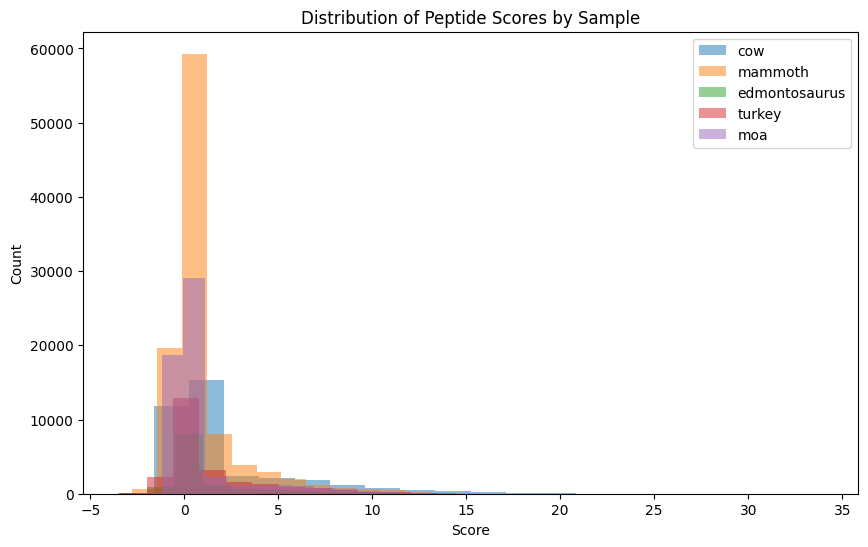

In [69]:
# Example: Create a histogram of peptide scores by sample
plt.figure(figsize=(10, 6))
for sample in df['actual_sample'].unique():
  sample_data = df[df['actual_sample'] == sample]
  plt.hist(sample_data['score'], alpha=0.5, label=sample, bins=20)
plt.legend()
plt.title('Distribution of Peptide Scores by Sample')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()


In [73]:
# Group by sample, protein, and accession ID
top_proteins_per_sample = (
    df.groupby(['actual_sample', 'protein', 'accession_id'])
    .size()
    .reset_index(name='count')
)

# For each sample, get top 5 proteins by count
top_5_per_sample = (
    top_proteins_per_sample
    .sort_values(['actual_sample', 'count'], ascending=[True, False])
    .groupby('actual_sample')
    .head(5)
)

# Display results
for sample in top_5_per_sample['actual_sample'].unique():
    sample_df = top_5_per_sample[top_5_per_sample['actual_sample'] == sample]
    print(f"\nTop 5 proteins for sample: {sample}")
    for _, row in sample_df.iterrows():
        print(f"  Protein: {row['protein']}")
        print(f"    Accession ID: {row['accession_id']}")
        print(f"    Count: {row['count']}")



Top 5 proteins for sample: cow
  Protein: >UPI|UPI0005FB0D4E|COL1A1|A0A6P7EH12.1|2015-04-04 
    Accession ID: UPI0005FB0D4E
    Count: 5289
  Protein: >UPI|UPI0003C01254|COL1A2|A0A8B9XLA1|2013-11-02 GN
    Accession ID: UPI0003C01254
    Count: 3488
  Protein: >UPI|UPI0011489AF3|COL1A2|A0A4W2DTI5|2019-05-29 GN
    Accession ID: UPI0011489AF3
    Count: 1084
  Protein: >UPI|UPI00114A632A|COL1A1|A0A4W2FAL4|2019-05-29 GN
    Accession ID: UPI00114A632A
    Count: 844
  Protein: >sp|P02465|CO1A2_BOVIN Collagen alpha-2(I) chain O
    Accession ID: P02465
    Count: 798

Top 5 proteins for sample: edmontosaurus
  Protein: >UPI|UPI00114A632A|COL1A1|A0A4W2FAL4|2019-05-29 GN
    Accession ID: UPI00114A632A
    Count: 267
  Protein: >UPI|UPI00108EA832|COL1A2|2019-03-14 GN=COL1A2 |{0
    Accession ID: UPI00108EA832
    Count: 174
  Protein: >UPI|UPI002AA64D36|COL1A2|2023-12-13 GN=COL1A2 |{0
    Accession ID: UPI002AA64D36
    Count: 115
  Protein: >UPI|UPI0006B135D9|COL1A1|2015-09-11 GN=COL1A1 